# Imports

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import norm
from scipy.optimize import curve_fit

# Load the datasets

In [50]:
# load dataset players
print("PLAYERS")
urlPlayers = '24-25/data_preprocess_merge.xlsx'
dataframePlayers = pd.read_excel(urlPlayers, header=0, index_col=None)
# summarize shape
print("Shape: " + str(dataframePlayers.shape))
# summarize first few lines
print("Summary Players")
print(dataframePlayers)

PLAYERS
Shape: (529, 26)
Summary Players
       Id Role Role_M              Name     Squad  Price  Age  MyRating  Mate  \
0    4431    P    Por       Carnesecchi  Atalanta     13   24       NaN   NaN   
1    2297    P    Por          Rossi F.  Atalanta      1   29       NaN   NaN   
2    4270    P    Por      Rui Patricio  Atalanta      1   36       NaN   NaN   
3    4887    D      E         Bellanova  Atalanta     13   24       NaN   NaN   
4    5354    D      E           Ruggeri  Atalanta     12   22       NaN   NaN   
..    ...  ...    ...               ...       ...    ...  ...       ...   ...   
524  6801    A     Pc         Tengstedt    Verona     12   24       NaN   NaN   
525  6630    A     Pc          Mosquera    Verona     10   25       NaN   NaN   
526  6644    A     Pc  Rocha Livramento    Verona      6   23       NaN   NaN   
527  6159    A      A           Sarr A.    Verona      4   23       NaN   NaN   
528  6490    A     Pc              Cruz    Verona      1   25       

# Initialize variables

In [51]:
roles = ['P', 'D', 'C', 'A']
roles_m = ['Por', 'Dc', 'B', 'Dd', 'Ds', 'E', 'M', 'C', 'W', 'T', 'Pc', 'A']
columns = ["Pg", "Mv", "Mf"]
current_season = "24-25"
seasons = ["23_24", "22_23", "21_22", "20_21", "19_20"]
min_matches = 11

# Create subdatasets given the roles of players

In [52]:
# Create the separate dataframes for ease of use
dataframeKeep = dataframePlayers[dataframePlayers['Role'] == roles[0]]
print("Esempio Portieri")
print(dataframeKeep)
dataframeDef = dataframePlayers[dataframePlayers['Role'] == roles[1]]
dataframeMid = dataframePlayers[dataframePlayers['Role'] == roles[2]]
dataframeAtt = dataframePlayers[dataframePlayers['Role'] == roles[3]]
# Put in one list
dataframes = [dataframeKeep, dataframeDef, dataframeMid, dataframeAtt]

# Create subsets given specific roles
df_m = []
for role in roles_m:
    df_temp = dataframePlayers[dataframePlayers['Role_M'].str.split(';').str[0] == role]
    print(df_temp)
    df_m.append(df_temp)
    

Esempio Portieri
       Id Role Role_M          Name     Squad  Price  Age  MyRating  Mate  \
0    4431    P    Por   Carnesecchi  Atalanta     13   24       NaN   NaN   
1    2297    P    Por      Rossi F.  Atalanta      1   29       NaN   NaN   
2    4270    P    Por  Rui Patricio  Atalanta      1   36       NaN   NaN   
25    133    P    Por     Skorupski   Bologna     11   33       NaN   NaN   
26   2722    P    Por   Ravaglia F.   Bologna      1   27       NaN   NaN   
..    ...  ...    ...           ...       ...    ...  ...       ...   ...   
476  6248    P    Por  Stankovic F.   Venezia      1   22       NaN   NaN   
477  6671    P    Por        Grandi   Venezia      1   31       NaN   NaN   
501  4957    P    Por      Montipo'    Verona      7   28       NaN   NaN   
502   511    P    Por       Perilli    Verona      1   29       NaN   NaN   
503  4491    P    Por    Berardi A.    Verona      1   33       NaN   NaN   

     Regularness  ...  Mf22_23  Pg21_22  Mv21_22  Mf21_22 

# Expected Mf

In [92]:
# Define a Gaussian function
def gaussian(x, mu, sigma, A):
    return A * np.exp(-(x - mu) ** 2 / (2 * sigma ** 2))

# Function to calculate expected performance for a given age
def expected_performance(x_values, model):
    return model(x_values)

# Function that returns the expected difference in performance for a given age
def expected_diff_performance(age, params):
    return expected_performance(age, params) - expected_performance(age-1, params)

## Performance by Age

**Visualization**

Por


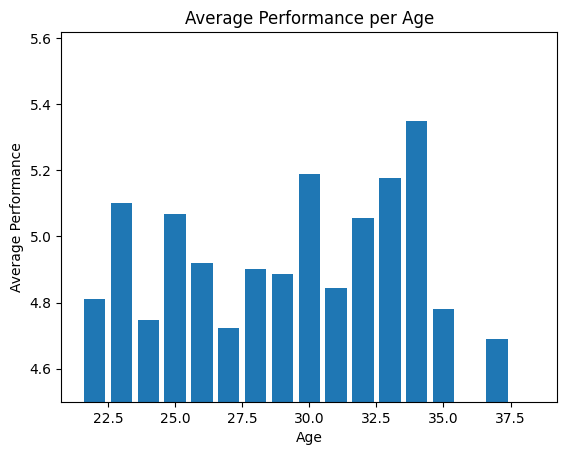

Average performance per role 4.911475409836065
Dc


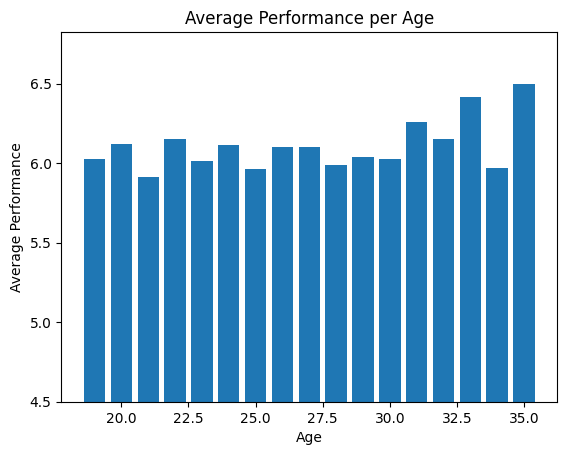

Average performance per role 6.069651162790698
B


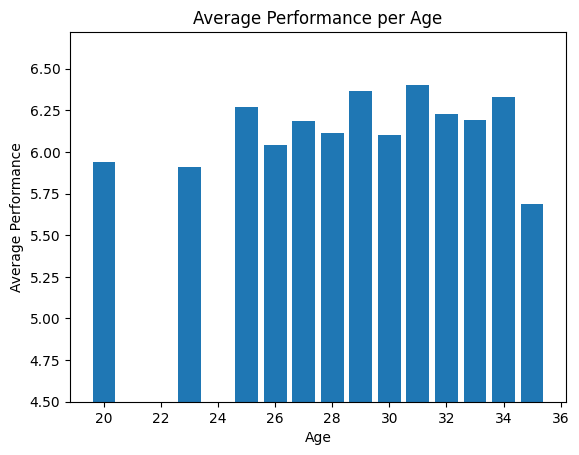

Average performance per role 6.168148148148149
Dd


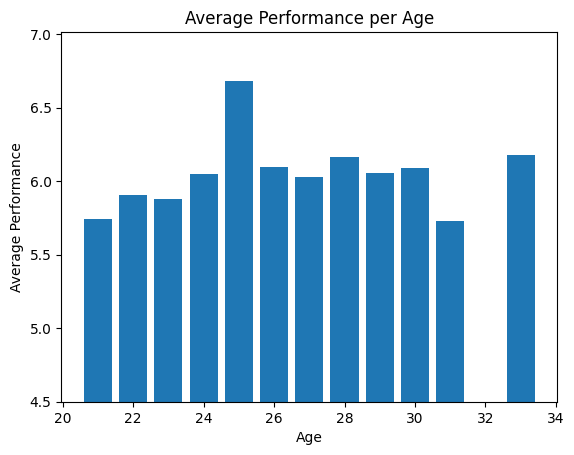

Average performance per role 6.047777777777777
Ds


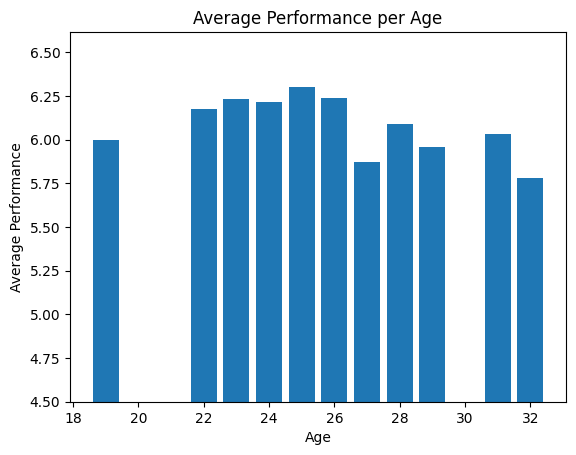

Average performance per role 6.108636363636364
E


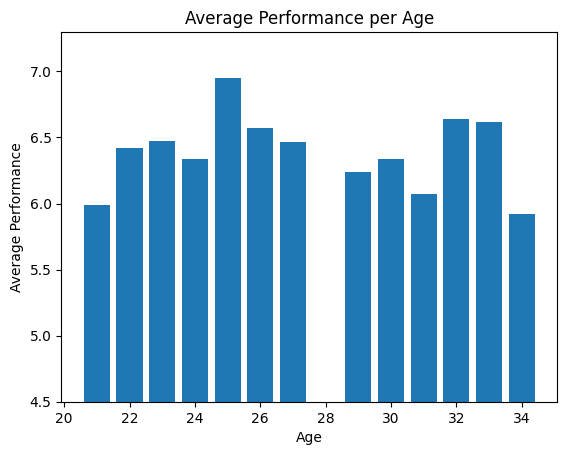

Average performance per role 6.42344827586207
M


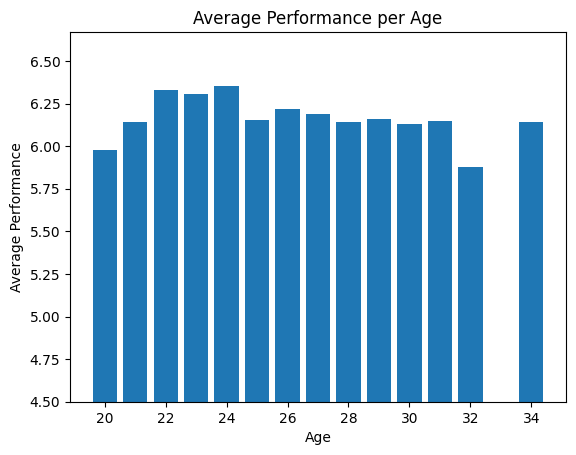

Average performance per role 6.187179487179488
C


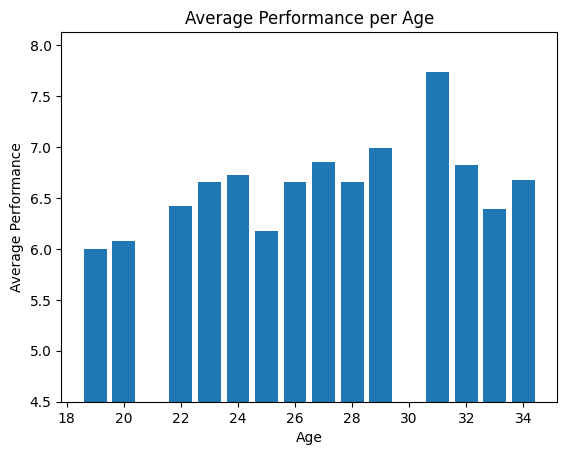

Average performance per role 6.56764705882353
W


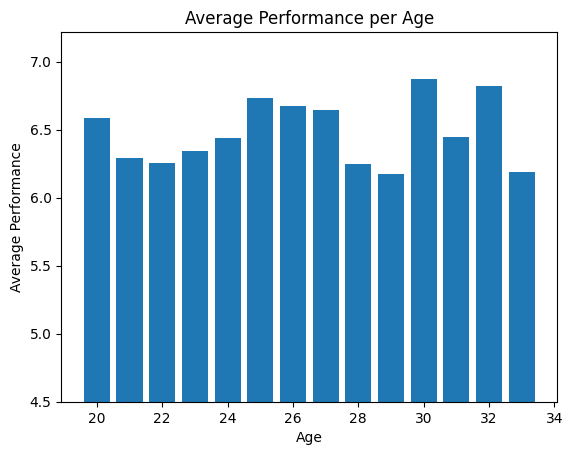

Average performance per role 6.474166666666666
T


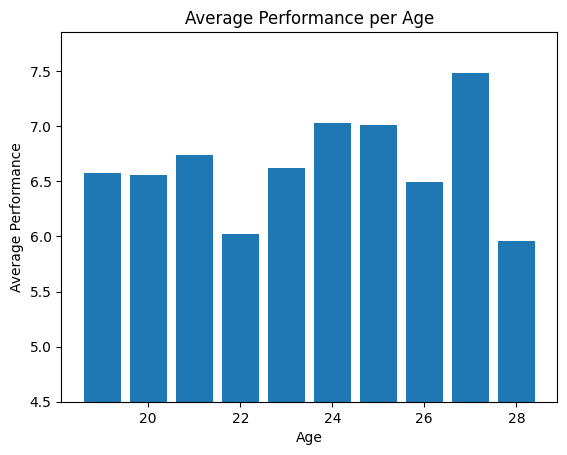

Average performance per role 6.708888888888889
Pc


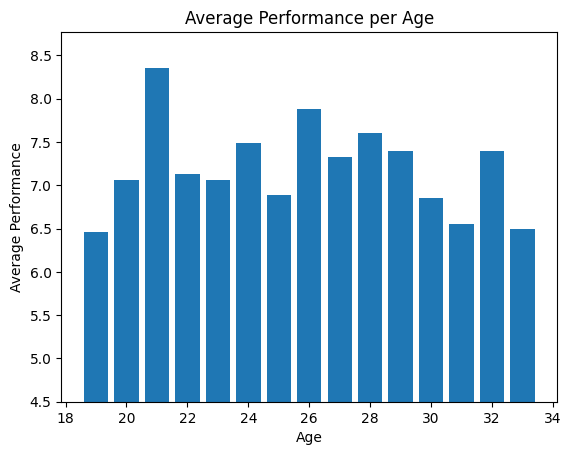

Average performance per role 7.277058823529412
A


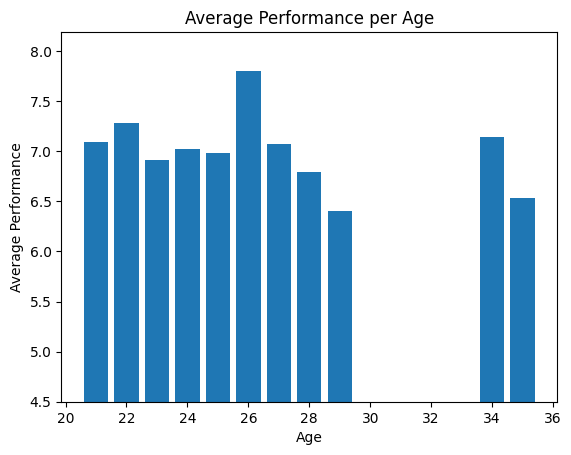

Average performance per role 7.087407407407407


In [54]:
matches_filter = [8,25,22,29,29,27,26,28,24,19,27,29]
# Fit the data to a Gaussian distribution to get mean and standard deviation
for i, df in enumerate(df_m):
    print(roles_m[i])
    players = []
    for index, row in df.iterrows():
        # Filter players
        for k in seasons:
            if row['Pg'+k] >= matches_filter[i]:
                players.append({
                    'Name': row['Name'],
                    'Age': row['Age']- 1 - seasons.index(k),
                    'MfPerformance': row['Mf'+k],
                    'MvPerformance': row['Mv'+k]
                    })
    new_df = pd.DataFrame(players)
    # Group by Age and calculate the average performance
    average_performance_per_age = new_df.groupby('Age')['MfPerformance'].mean()

    # Plot the histogram
    plt.bar(average_performance_per_age.index, average_performance_per_age.values)
    plt.ylim(bottom = 4.5)
    plt.xlabel('Age')
    plt.ylabel('Average Performance')
    plt.title('Average Performance per Age')
    plt.show()
    print(f"Average performance per role {new_df['MfPerformance'].mean()}")

**Regression**

Por


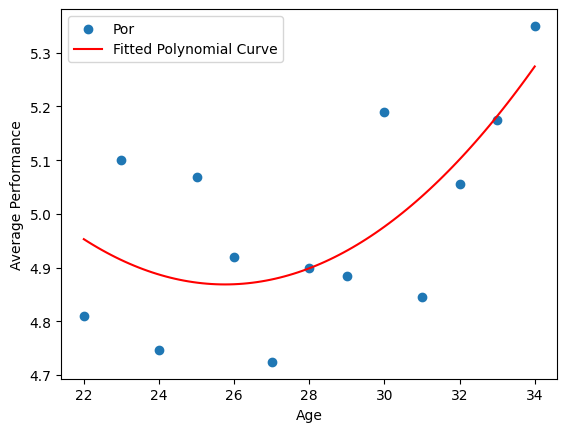

Dc


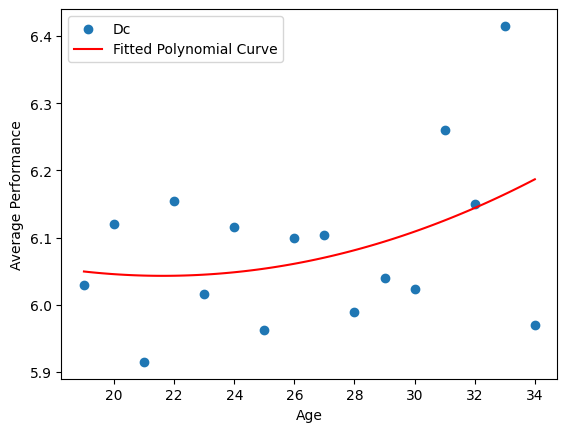

B


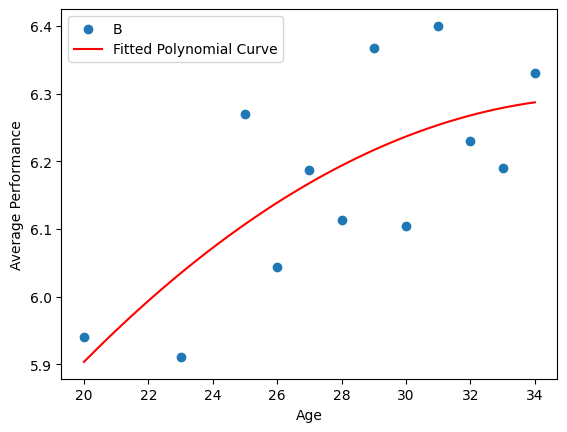

Dd


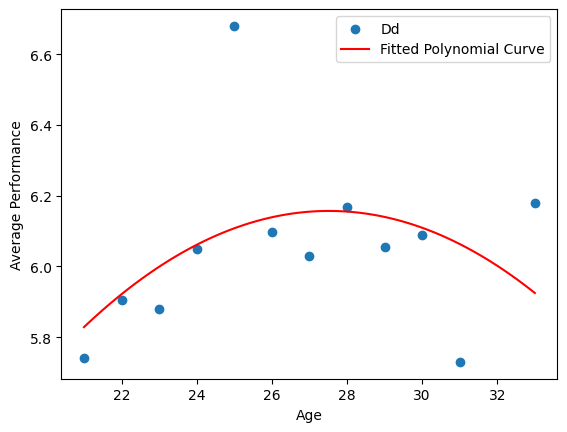

Ds


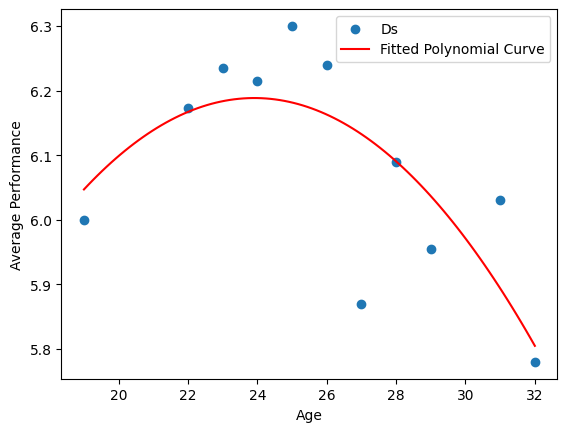

E


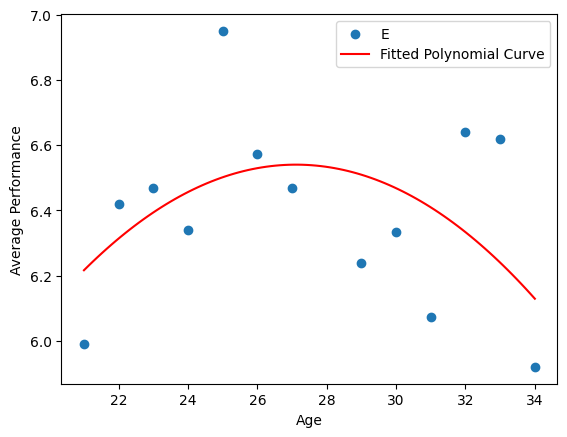

M


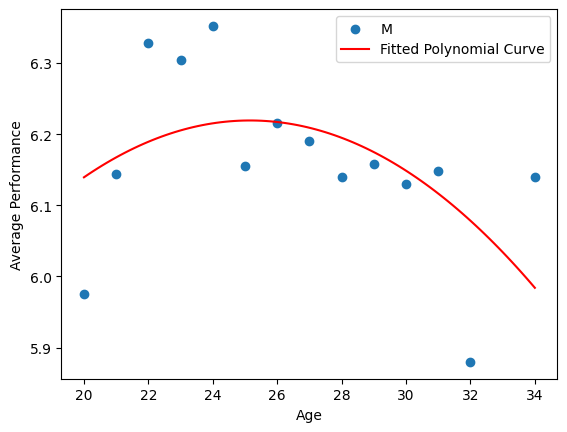

C


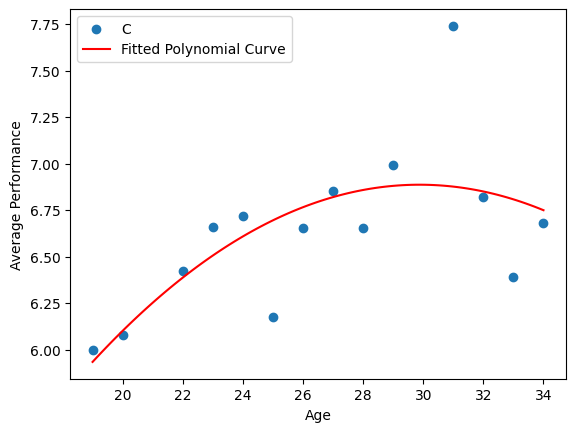

W


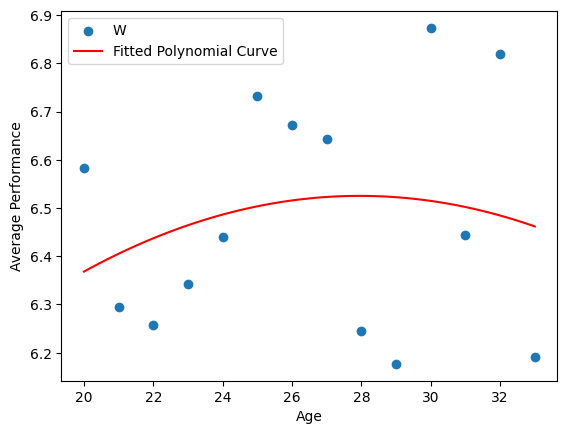

T


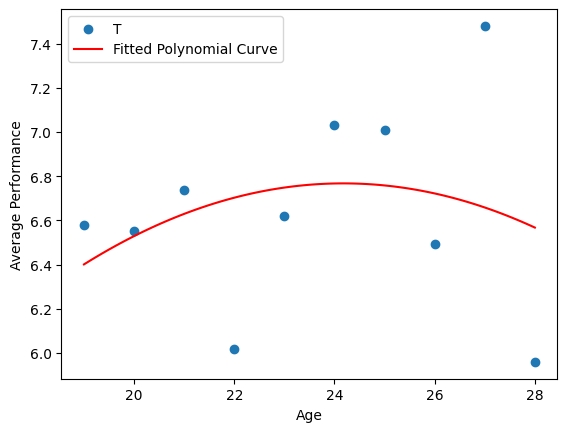

Pc


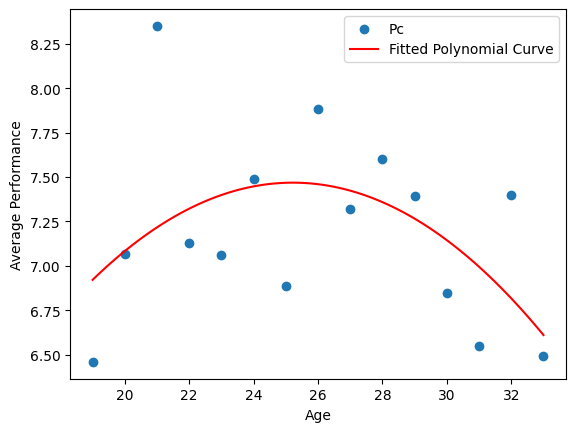

A


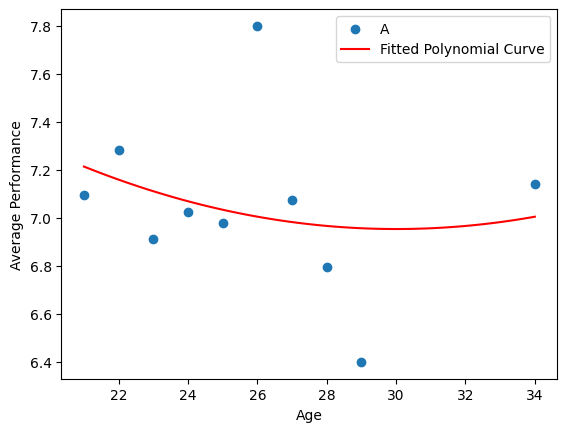

In [64]:
from numpy.polynomial.polynomial import Polynomial

stats_models = []
# Fit the data to a Gaussian distribution to get mean and standard deviation
for i, df in enumerate(df_m):
    print(roles_m[i])
    players = []
    for index, row in df.iterrows():
        # Filter players
        for k in seasons:
            if row['Pg' + k] >= matches_filter[i]:
                players.append({
                    'Name': row['Name'],
                    'Age': row['Age'] - 1 - seasons.index(k),
                    'MfPerformance': row['Mf' + k],
                    'MvPerformance': row['Mv' + k]
                })
    
    new_df = pd.DataFrame(players)

    # **Filter out players older than 34**
    new_df = new_df[new_df['Age'] <= 34]

    # Group by Age and calculate the average performance
    average_performance_per_age = new_df.groupby('Age')['MfPerformance'].mean()

    # x and y are your age and performance arrays
    x = average_performance_per_age.index
    y = average_performance_per_age.values

    # Fit a polynomial regression model (degree 2 for simplicity)
    p = Polynomial.fit(x, y, deg=2)

    # **Append the fitted model to the stats_models list**
    stats_models.append(p)

    # Generate predictions from the model
    x_fit = np.linspace(min(x), max(x), 100)
    y_fit = p(x_fit)

    # Plot the original data and the fitted curve
    plt.scatter(x, y, label=roles_m[i])
    plt.plot(x_fit, y_fit, 'r-', label='Fitted Polynomial Curve')
    plt.xlabel('Age')
    plt.ylabel('Average Performance')
    plt.legend()
    plt.show()


## Performance by FVM

**Visualization**

Por


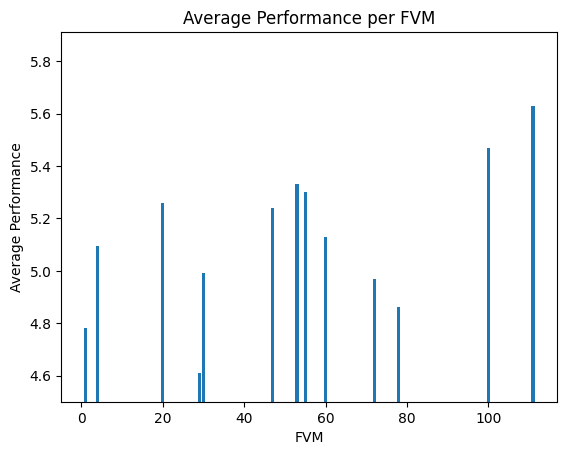

Dc


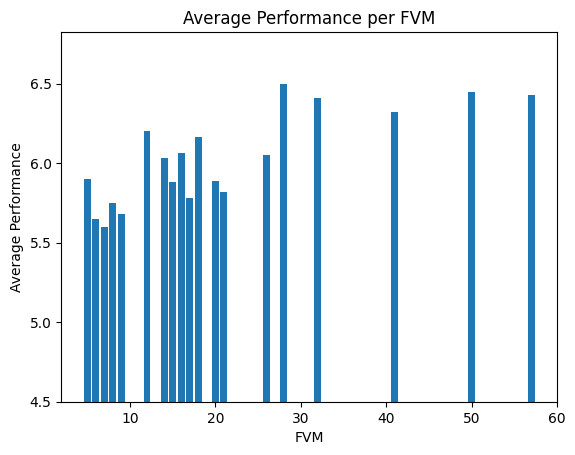

B


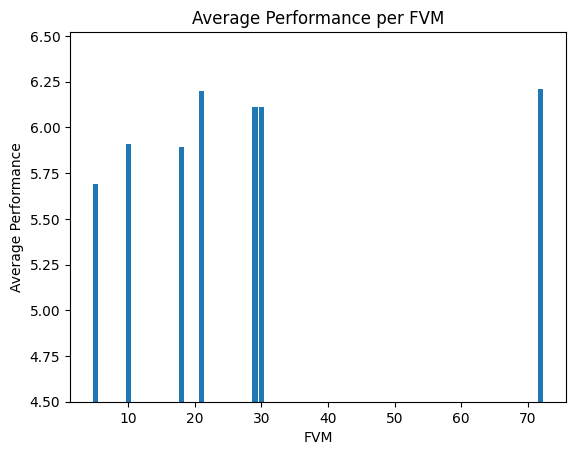

Dd


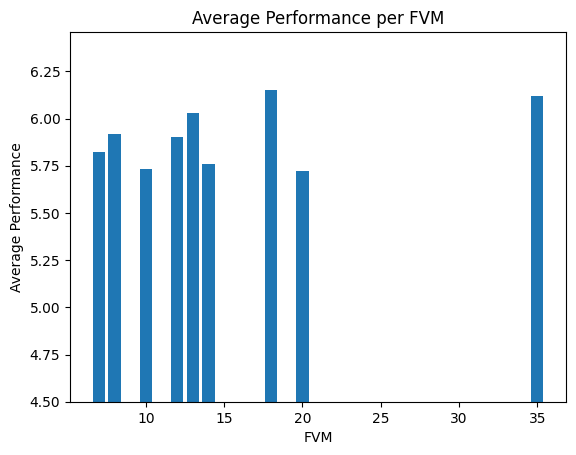

Ds


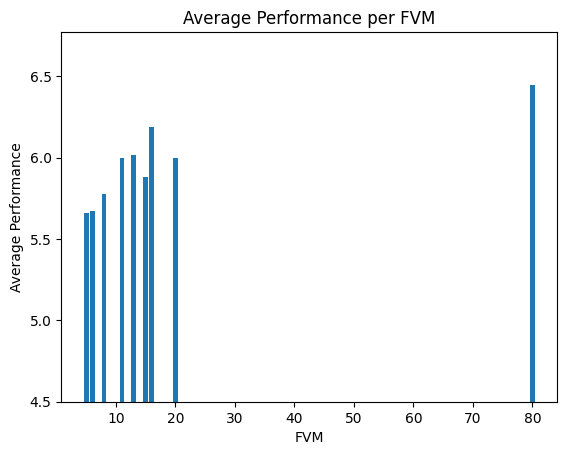

E


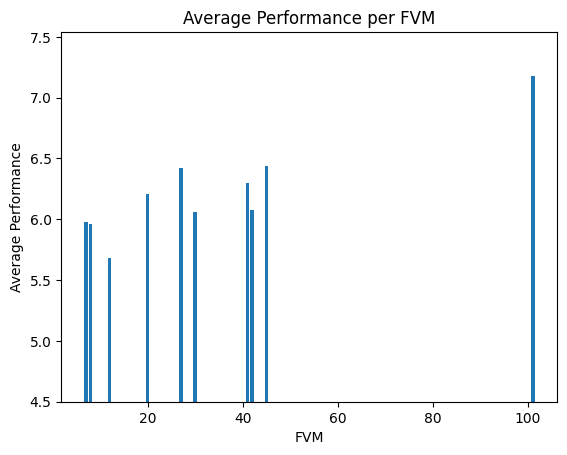

M


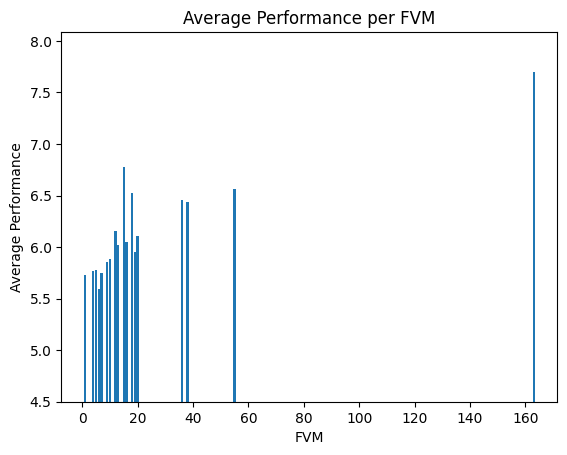

C


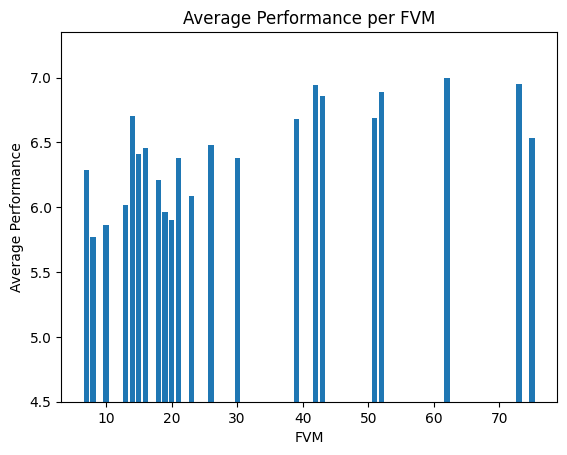

W


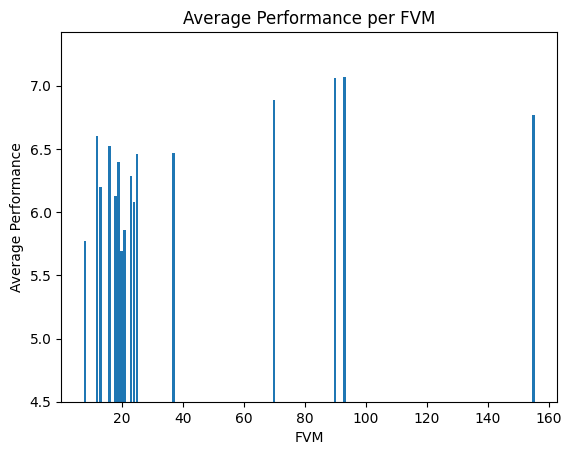

T


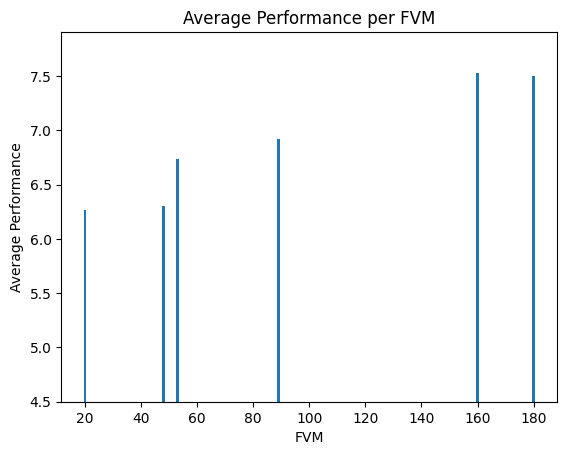

Pc


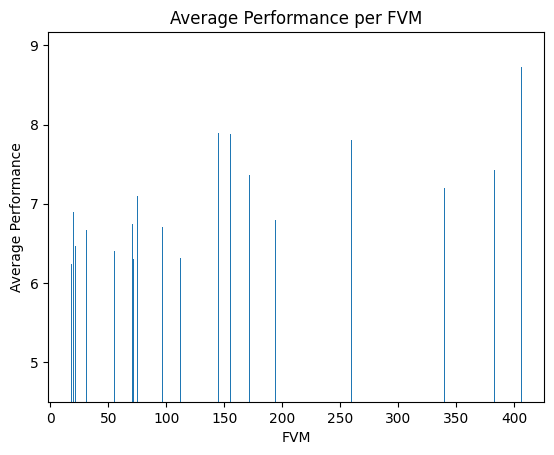

A


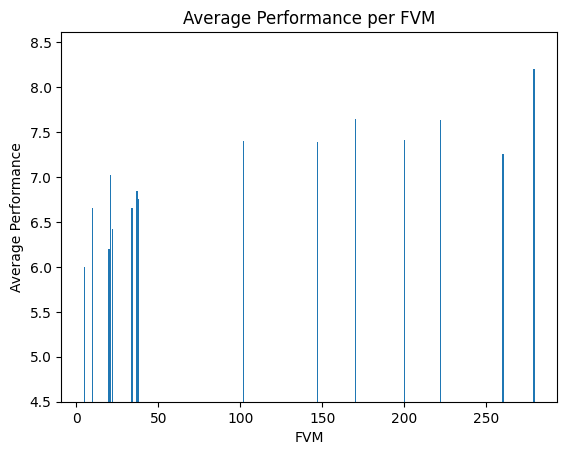

In [65]:
for i, df in enumerate(df_m):
    print(roles_m[i])
    players = []
    for index, row in df.iterrows():
        # Filter players
        
        if row['Pg23_24'] >= 22:
            players.append({
                'Name': row['Name'],
                'FVM': row['FVM'],
                'MfPerformance': row['Mf23_24'],
                'MvPerformance': row['Mv23_24']
                })
    new_df = pd.DataFrame(players)
    # Group by Age and calculate the average performance
    average_performance_per_age = new_df.groupby('FVM')['MfPerformance'].mean()

    # Plot the histogram
    plt.bar(average_performance_per_age.index, average_performance_per_age.values)
    plt.ylim(bottom = 4.5)
    plt.xlabel('FVM')
    plt.ylabel('Average Performance')
    plt.title('Average Performance per FVM')
    plt.show()

**Regression**

Por


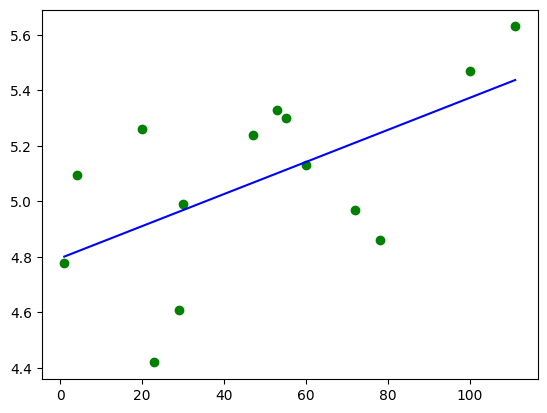

Dc


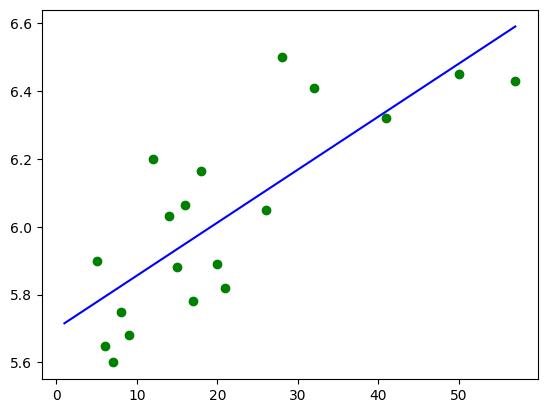

B


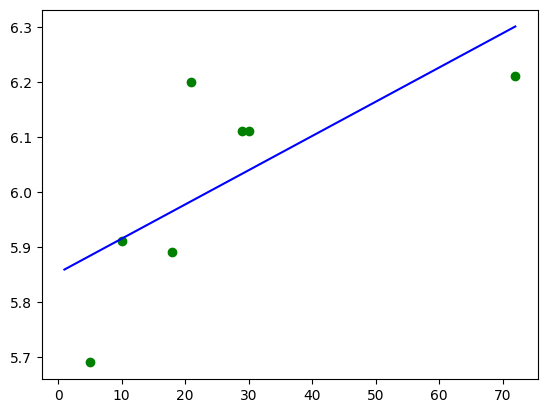

Dd


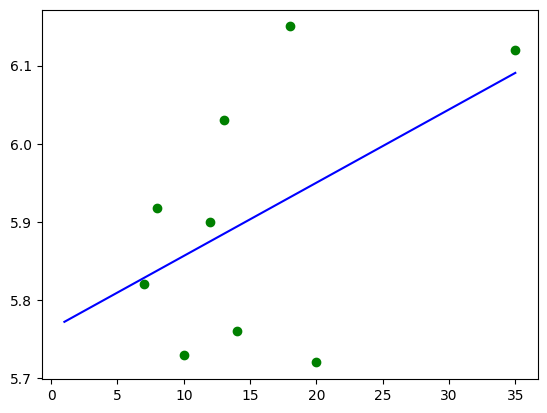

Ds


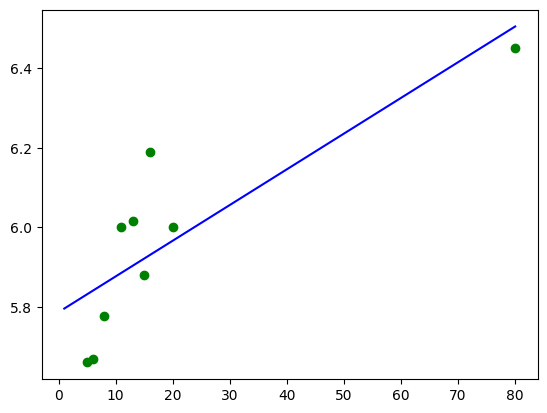

E


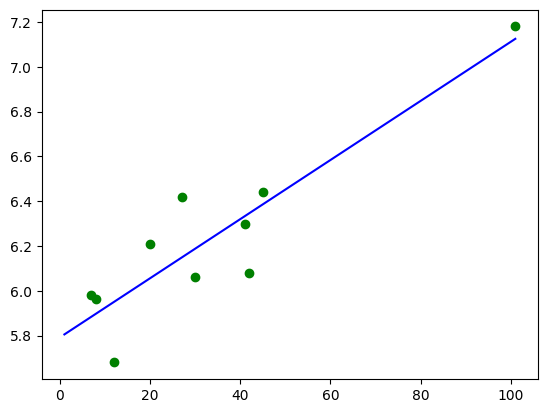

M


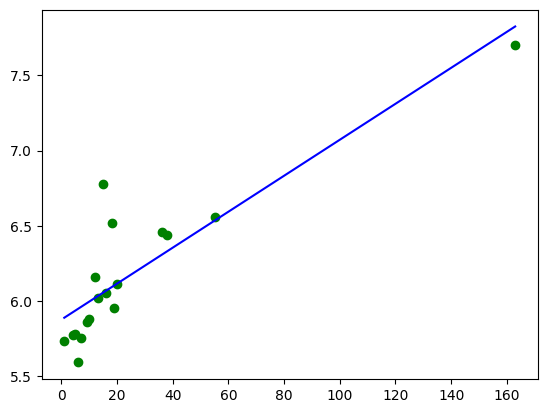

C


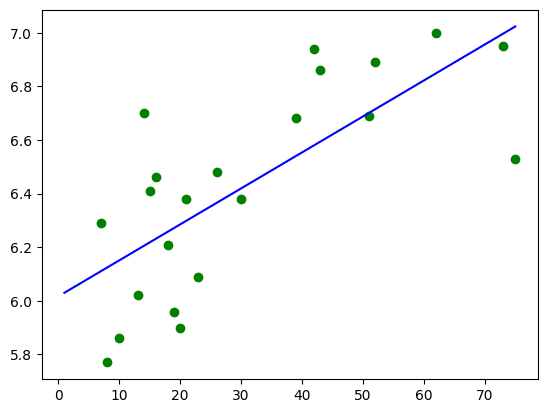

W


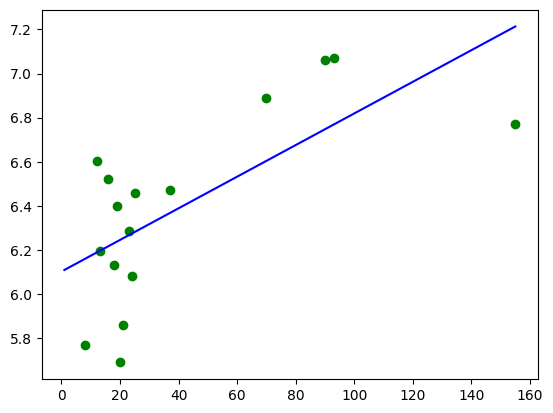

T


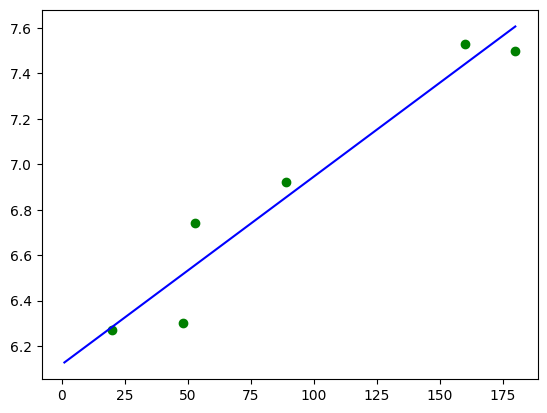

Pc


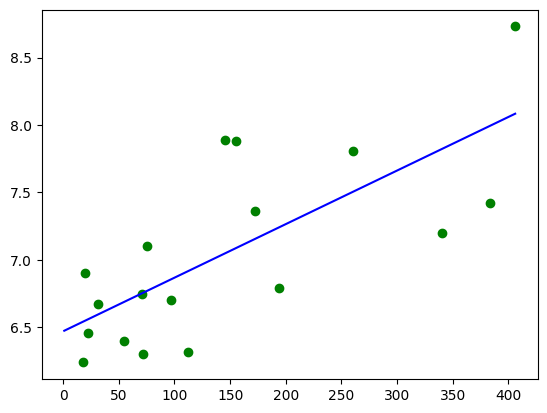

A


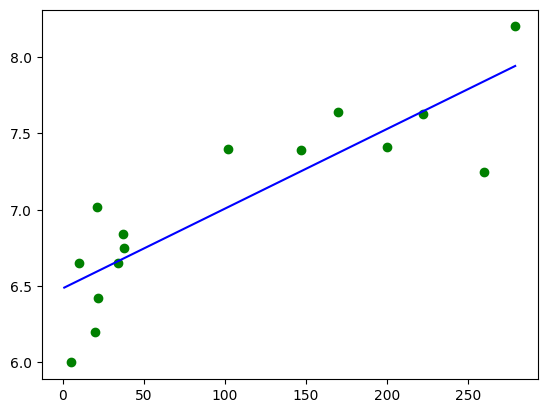

In [66]:
# Regressions per role
fvm_models = []
for i, df in enumerate(df_m):
    print(roles_m[i])
    players = []
    for index, row in df.iterrows():
        # Filter players
        if row['Pg23_24'] >= 22:
            players.append({
                'Name': row['Name'],
                'FVM': row['FVM'],
                'MfPerformance': row['Mf23_24'],
                'MvPerformance': row['Mv23_24']
                })
    new_df = pd.DataFrame(players)
    # Group by Age and calculate the average performance
    average_performance_per_age = new_df.groupby('FVM')['MfPerformance'].mean()

    # Fit the data to a curve
    x_data = average_performance_per_age.index
    y_data = average_performance_per_age.values

    model = np.poly1d(np.polyfit(x_data, y_data, 1))
    fvm_models.append(model)
    
    myline = np.linspace(1, max(x_data), 100)

    plt.scatter(x_data, y_data, color='green')
    plt.plot(myline, model(myline), color='blue')
    plt.show()

## Get Expected Performance for Next Season

In [114]:
# Create a new column with NaN values
new_column = pd.Series([np.nan] * len(dataframePlayers), name='ExpectedMf')
for index, row in dataframePlayers.iterrows():
    # Get index of role
    role = row['Role_M'].split(';')[0]
    i = roles_m.index(role)
    # Get fvm expected performance
    fvm_perf = fvm_models[i](row['FVM'])
    # Get age expected performance
    if row['Mf'+seasons[0]] != 0 and row['Pg'+seasons[0]] >= 16:
        weight_fvm = 0.5
        weight_age = 0.5
        age_perf = row['Mf'+seasons[0]] + expected_diff_performance(row['Age'], stats_models[i])
    else:
        weight_fvm = 0.5
        weight_age = 0.5
        age_perf = expected_performance(row['Age'], stats_models[i])
    weighted_perf = weight_fvm * fvm_perf + weight_age * age_perf
    if row['Name'] == 'Lukaku':
        print(f"FVM avg:{fvm_perf}\nAge avg:{age_perf}")
    dataframePlayers.at[index, 'ExpectedMf'] = round(weighted_perf, 2)
'''for i in range(4):
    diffs = []
    for k in range(18, 36):
        diffs.append(expected_diff_performance(k, *stats_models[i]))
    print(f"Difference for {roles[i]}: {diffs}")'''
print(dataframePlayers.loc[dataframePlayers['Name']=='Kvaratskhelia'])

FVM avg:7.821453651966678
Age avg:7.05049271439345
       Id Role Role_M           Name   Squad  Price  Age  MyRating  Mate  \
369  5839    A      A  Kvaratskhelia  Napoli     30   23       NaN   NaN   

     Regularness  ...  Pg21_22  Mv21_22  Mf21_22  Pg20_21  Mv20_21  Mf20_21  \
369          NaN  ...      NaN      NaN      NaN      NaN      NaN      NaN   

     Pg19_20  Mv19_20  Mf19_20  ExpectedMf  
369      NaN      NaN      NaN        7.52  

[1 rows x 27 columns]


# Recreate subdatasets given the roles of players

In [ ]:
# Create the separate dataframes for ease of use
dataframeKeep = dataframePlayers[dataframePlayers['Role'] == roles[0]]
print("Esempio Portieri")
print(dataframeKeep)
dataframeDef = dataframePlayers[dataframePlayers['Role'] == roles[1]]
dataframeMid = dataframePlayers[dataframePlayers['Role'] == roles[2]]
dataframeAtt = dataframePlayers[dataframePlayers['Role'] == roles[3]]
# Put in one list
dataframes = [dataframeKeep, dataframeDef, dataframeMid, dataframeAtt]

Esempio Portieri
       Id Role          Name     Squad  Price  Age  MyRating Mate  \
0    4431    P   Carnesecchi  Atalanta     13   24       NaN  NaN   
1    2792    P         Musso  Atalanta      4   30       NaN  NaN   
2    2297    P      Rossi F.  Atalanta      1   29       NaN  NaN   
25    133    P     Skorupski   Bologna     12   33       NaN  NaN   
26   2722    P   Ravaglia F.   Bologna      1   27       NaN  NaN   
..    ...  ...           ...       ...    ...  ...       ...  ...   
465  6248    P  Stankovic F.   Venezia      1   22       NaN  NaN   
466  6671    P        Grandi   Venezia      1   31       NaN  NaN   
492  4957    P      Montipo'    Verona      8   28       NaN  NaN   
493   511    P       Perilli    Verona      1   29       NaN  NaN   
494  4491    P    Berardi A.    Verona      1   33       NaN  NaN   

     Regularness  FVM  ...  Pg21_22  Mv21_22  Mf21_22  Pg20_21  Mv20_21  \
0              4   55  ...      NaN      NaN      NaN      0.0     0.00   
1   

# Rating Assignment

## Compute Layers for Rating

We need to set some levels of "goodness".

The levels are based on the statistics of last years in order to give an objective rating on the players.

They will be used with orders of importance, 22/23 is more important than 19/20.

**Media FantaVoto**

P


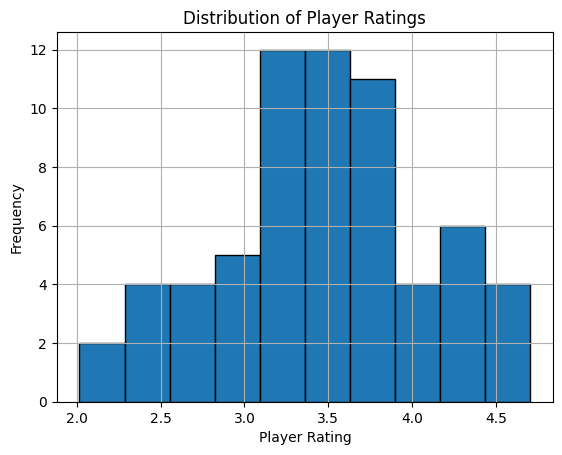

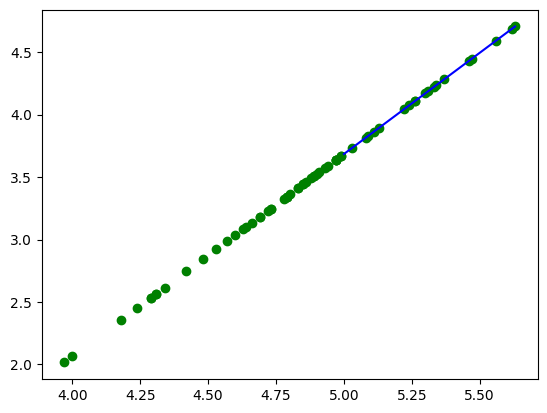

D


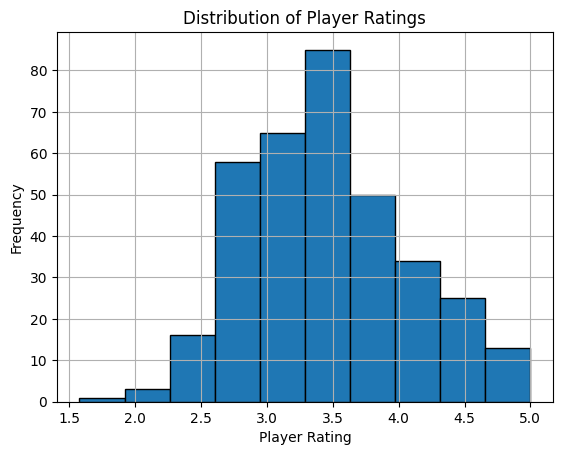

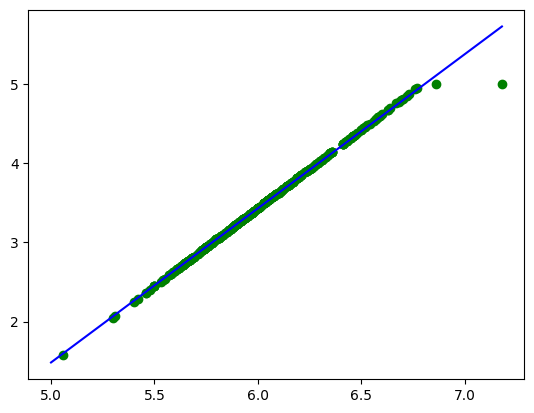

C


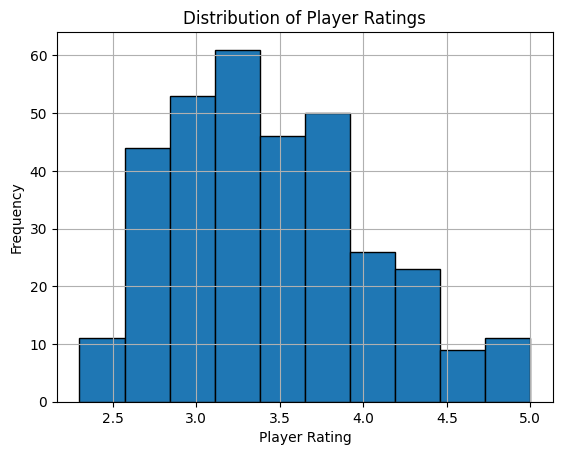

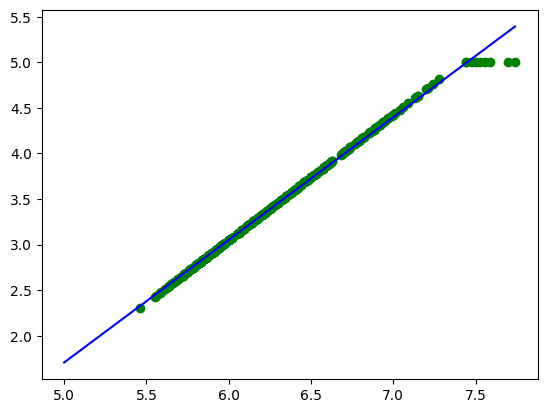

A


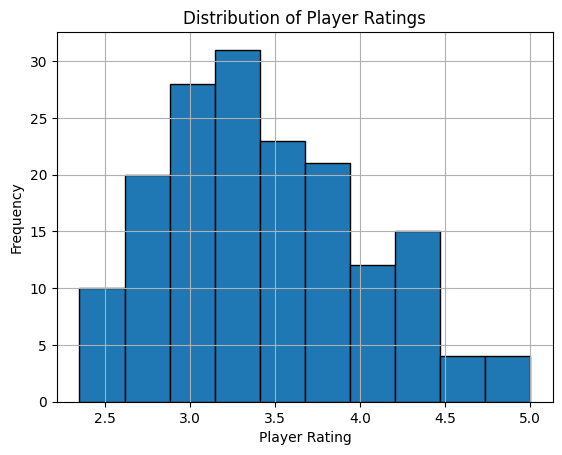

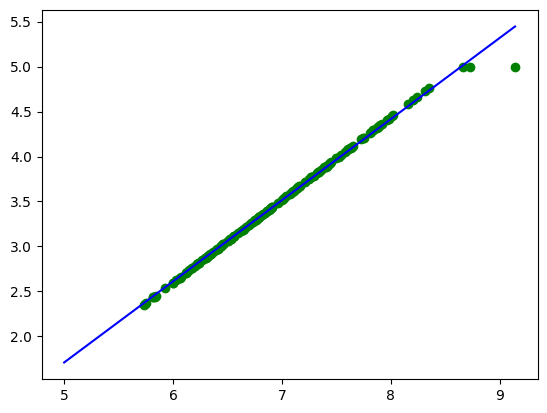

In [ ]:
# Function to map z-scores to ratings
def map_to_rating(z_score):
    # Linear mapping from z-score to rating scale (1 to 10)
    min_z = -4  # Minimum z-score
    max_z = 2.5   # Maximum z-score
    min_rating = 1
    max_rating = 5
    
    # Map z-score to rating
    rating = min_rating + ((max_rating - min_rating) * (z_score - min_z) / (max_z - min_z))
    
    # Ensure rating is within the valid range
    return max(min(rating, max_rating), min_rating)

# Initialize levels array
stats_models = []

# Fit the data to a Gaussian distribution to get mean and standard deviation
for i, df in enumerate(dataframes):
    print(roles[i])
    # Filter players that didn't play enough
    votes = []
    for season in seasons:
        filtered_df = df[df['Pg' + season] > min_matches]
        # Get the array of FantaVoti
        votes.append(filtered_df['Mf' + season].to_numpy())
    votes = np.concatenate(votes)

    # Calculate mean and standard deviation
    mean_value = np.mean(votes)
    std_dev = np.std(votes)

    # Calculate z-scores and map to ratings for each player
    player_ratings = []
    for value in votes:
        z_score = (value - mean_value) / std_dev
        rating = map_to_rating(z_score)
        player_ratings.append(rating)

    # Plot histogram of player ratings
    plt.hist(player_ratings, bins=10, edgecolor='black')
    plt.xlabel('Player Rating')
    plt.ylabel('Frequency')
    plt.title('Distribution of Player Ratings')
    plt.grid(True)
    plt.show()

    x_data = votes
    y_data = player_ratings

    model = np.poly1d(np.polyfit(x_data, y_data, 1))
    stats_models.append(model)
    
    myline = np.linspace(5, max(x_data), 100)

    plt.scatter(x_data, y_data, color='green')
    plt.plot(myline, model(myline), color='blue')
    plt.show()

**FVM**

In [ ]:
log_base = 1.2

P


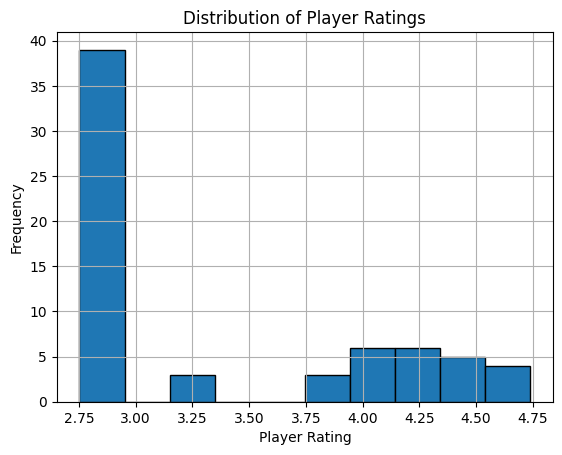

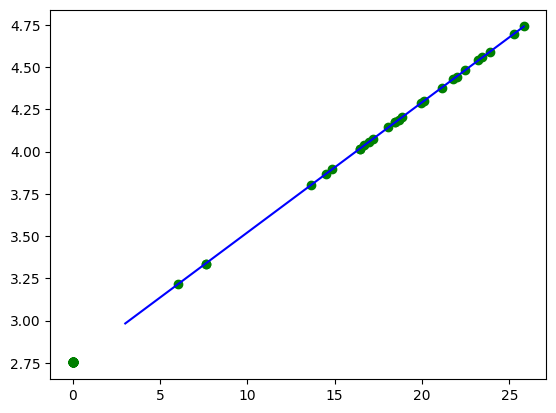

D


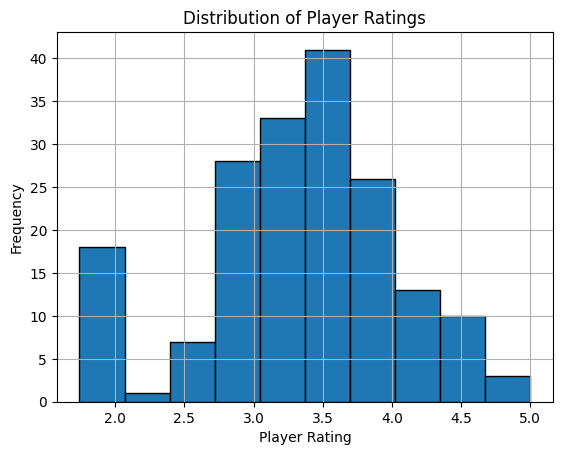

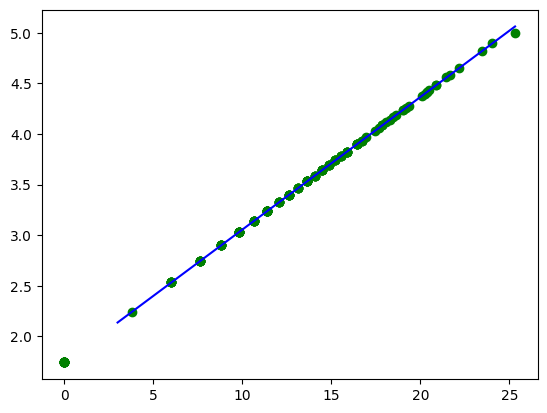

C


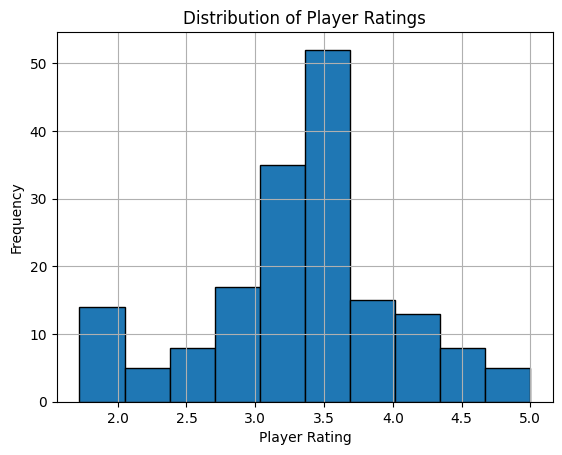

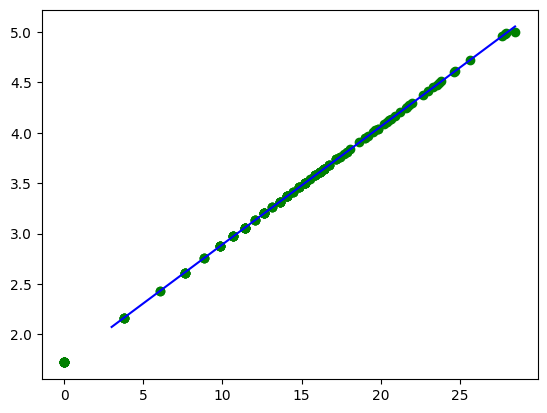

A


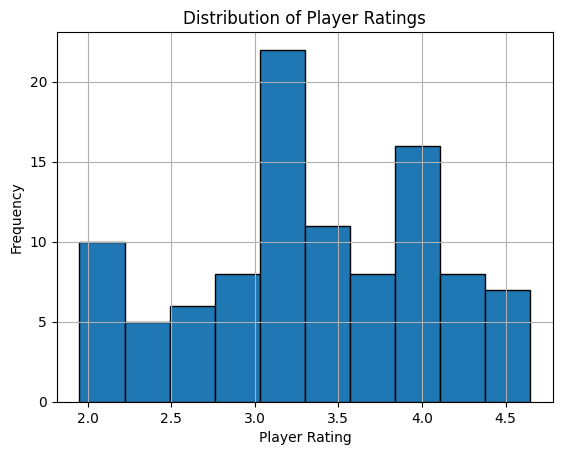

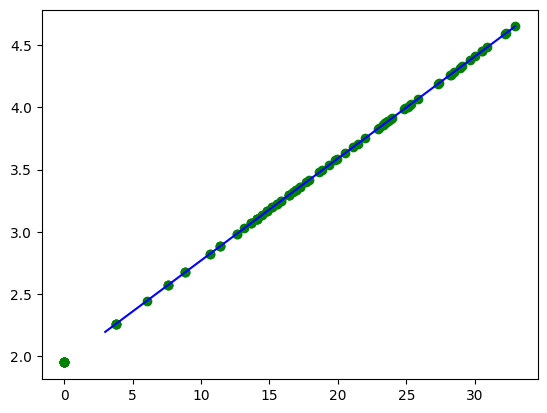

In [ ]:
# Function to map z-scores to ratings
def map_to_rating(z_score):
    # Linear mapping from z-score to rating scale (1 to 10)
    min_z = -2.5  # Minimum z-score
    max_z = 2.3   # Maximum z-score
    min_rating = 1.5
    max_rating = 5
    
    # Map z-score to rating
    rating = min_rating + ((max_rating - min_rating) * (z_score - min_z) / (max_z - min_z))
    
    # Ensure rating is within the valid range
    return max(min(rating, max_rating), min_rating)

# Initialize levels array
fvm_models = []

# Fit the data to a Gaussian distribution to get mean and standard deviation
for i, df in enumerate(dataframes):
    print(roles[i])
    # Get the array of FantaVoti
    votes = df['FVM'].to_numpy()

    votes = np.log(votes) / np.log(log_base)

    # Calculate mean and standard deviation
    mean_value = np.mean(votes)
    std_dev = np.std(votes)

    # Calculate z-scores and map to ratings for each player
    player_ratings = []
    for value in votes:
        z_score = (value - mean_value) / std_dev
        rating = map_to_rating(z_score)
        player_ratings.append(rating)

    # Plot histogram of player ratings
    plt.hist(player_ratings, bins=10, edgecolor='black')
    plt.xlabel('Player Rating')
    plt.ylabel('Frequency')
    plt.title('Distribution of Player Ratings')
    plt.grid(True)
    plt.show()

    x_data = votes
    y_data = player_ratings

    model = np.poly1d(np.polyfit(x_data, y_data, 1))
    fvm_models.append(model)
    
    myline = np.linspace(3, max(x_data), 100)

    plt.scatter(x_data, y_data, color='green')
    plt.plot(myline, model(myline), color='blue')
    plt.show()

## Assign the Ratings

In [ ]:
weight_fvm = 0.4
weight_stat = 0.6

# Initialize with the fvmValues
for index, row in dataframePlayers.iterrows():
    # Get index of role
    i = roles.index(row['Role'])
    # Apply log scale to FVM
    log_fvm = np.log(row['FVM']) / np.log(log_base)
    # Get FVM rating
    fvm_rating = fvm_models[i](log_fvm)
    if fvm_rating > 5:
        fvm_rating = 5
    # print("FVM rating of " + row['Name'] + ": " + str(fvm_rating))
    # Initialize stats ratings array
    stats_rating = stats_models[i](row['ExpectedMf'])
    if stats_rating > 5:
        stats_rating = 5
    #print(stats_array)
    dataframePlayers.at[index, 'MyRating'] = round(fvm_rating * weight_fvm + stats_rating * weight_stat, 1)
    

# Convert the 'MyRating' column to integers
#dataframePlayers['MyRating'] = dataframePlayers['MyRating'].astype(int)
#print(dataframePlayers)

print(dataframePlayers.loc[dataframePlayers['Name']=='Martinez Quarta'])

       Id Role             Name       Squad  Price  Age  MyRating Mate  \
139  5323    D  Martinez Quarta  Fiorentina     11   28       4.2  NaN   

     Regularness  FVM  ...  Pg21_22  Mv21_22  Mf21_22  Pg20_21  Mv20_21  \
139            5   32  ...     18.0     5.81     5.75     19.0     5.87   

     Mf20_21  Pg19_20  Mv19_20  Mf19_20  ExpectedMf  
139     5.87      NaN      NaN      NaN        6.38  

[1 rows x 26 columns]


# Save the ratings

In [115]:
dataframePlayers.to_csv(current_season+'/output_rp.csv', index=False, sep=',', encoding='utf-8')
dataframePlayers.to_excel(current_season+"/output_rp_excel.xlsx", index=False)